In [112]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from pytorch_forecasting import TemporalFusionTransformer, RecurrentNetwork
import torchmetrics
from pytorch_forecasting.metrics import MAE, RMSE

sys.path.append("../src")
# from gcn import KubernetesA3TGCN, create_dataset
from a3tgcn import KubernetesA3TGCN, create_dataset
from recurrent import get_dataset

In [3]:
a3tgcn = KubernetesA3TGCN(12, 10, 1)
a3tgcn.load_state_dict(torch.load("../models/agcn.pt"))

a3tgcn.to("cpu")

KubernetesA3TGCN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(12, 10)
      (linear_z): Linear(in_features=20, out_features=10, bias=True)
      (conv_r): GCNConv(12, 10)
      (linear_r): Linear(in_features=20, out_features=10, bias=True)
      (conv_h): GCNConv(12, 10)
      (linear_h): Linear(in_features=20, out_features=10, bias=True)
    )
  )
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

In [4]:
node_features = np.load("../data/test/node_features.npz")
edge_features = np.load("../data/test/edge_features.npz")

X, y = node_features["X"], node_features["y"]
A = edge_features["A"]

k8s_dataset = create_dataset(X, A, y, 0)

In [9]:
y_test = []
p_test = []
for (x, edge_index, edge_attr, y) in k8s_dataset:
    # x = snapshot.x.to(device)
    # edge_index = snapshot.edge_index.to(device)
    # edge_attr = snapshot.edge_attr.to(device)
    # y = snapshot.y.to(device)
    # 
    # y_pred = model(x.unsqueeze(2), edge_index, edge_attr)
    y_test.append(y[1].numpy())
    p_test.append(
        # model(x[1].unsqueeze(0), edge_index[1]).detach().numpy().ravel()
        a3tgcn(x[1].unsqueeze(2), edge_index[1], edge_attr[1]).detach().numpy().ravel()
    )
y_test = np.vstack(y_test)
p_test = np.vstack(p_test)

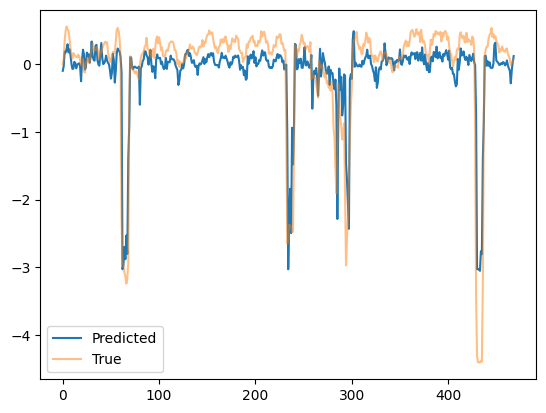

In [209]:
pod_feature = 5
plt.plot(p_test[:, pod_feature], label="Predicted")
plt.plot(y_test[:, pod_feature], label="True", alpha=0.5)
plt.legend();

In [26]:
np.mean((y_test - p_test) ** 2)

3.8336954

In [33]:
np.mean((y_test - p_test) ** 2, axis=0)

array([ 6.8976293 ,  0.4201356 ,  1.5031146 , 23.438538  ,  1.44299   ,
        0.16732927,  2.348727  ,  0.32540467,  1.0447358 ,  2.2359612 ,
        2.3461046 ], dtype=float32)

## Temporal-Fusion Transformer

In [155]:
tft = TemporalFusionTransformer.load_from_checkpoint("../models/tft.ckpt")
tft.eval()

TemporalFusionTransformer(
  	"attention_head_size":               8
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_continuous_size":            10
  	"hidden_continuous_sizes":           {}
  	"hidden_size":                       485
  	"learning_rate":                     0.0647
  	"log_gradient_flow":                 False
  	"log_interval":                      10
  	"log_val_interval":                  10
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	)
  	"loss":                              MultiLoss(QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9,

In [156]:
recurrent_dataset = get_dataset("../data/test", 0, 12)
dataloader = recurrent_dataset.to_dataloader(train=False, batch_size=1)

In [196]:
tft_predictions = tft.predict(dataloader, return_y=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [197]:
p_tft = torch.cat(tft_predictions.output, axis=1).swapaxes(0, 1).cpu().detach().numpy()
y_tft = torch.cat(tft_predictions.y[0]).cpu().detach().numpy()

In [198]:
np.mean((y_tft - p_tft) ** 2)

4.2328143

In [199]:
np.mean((y_tft - p_tft) ** 2, axis=0)

array([2.07518592e-01, 1.83098301e-01, 2.04261601e-01, 4.98765081e-01,
       6.25669181e-01, 5.78764141e-01, 8.12750757e-01, 9.53260601e-01,
       1.13188028e+00, 1.09595537e+00, 6.20069325e-01, 1.83243260e-01,
       1.36788517e-01, 2.05932200e-01, 2.80577153e-01, 2.61667073e-01,
       1.58807620e-01, 1.25716507e-01, 1.68876514e-01, 2.23327920e-01,
       2.23990783e-01, 1.70057878e-01, 2.42597237e-01, 1.86288446e-01,
       8.74367282e-02, 9.30529535e-02, 9.88474637e-02, 1.10276699e-01,
       8.79515111e-02, 7.44651631e-02, 8.08492675e-02, 9.54864472e-02,
       1.80141136e-01, 1.66817844e-01, 1.58015147e-01, 1.54713631e-01,
       1.88896611e-01, 2.17182487e-01, 1.94735676e-01, 1.93166777e-01,
       1.72209248e-01, 1.80393711e-01, 1.48589432e-01, 1.67727739e-01,
       1.37452453e-01, 1.82020798e-01, 1.78263679e-01, 2.13543415e-01,
       1.44953355e-01, 1.73028782e-01, 1.62214726e-01, 2.21298561e-01,
       1.75097212e-01, 1.34912238e-01, 1.45454153e-01, 1.30470186e-01,
      

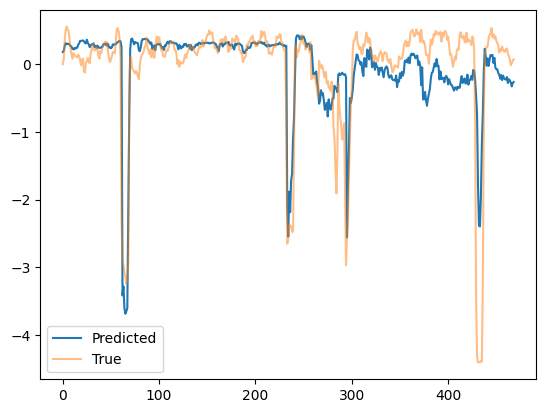

In [210]:
plt.plot(p_tft[pod_feature], label="Predicted")
plt.plot(y_tft[pod_feature], label="True", alpha=0.5)
plt.legend();

## RNN

In [184]:
rnn = RecurrentNetwork.load_from_checkpoint("../models/rnn.ckpt")
rnn.eval();

In [189]:
rnn_predictions = rnn.predict(dataloader, return_y=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [190]:
p_rnn = torch.cat(rnn_predictions.output, axis=1).swapaxes(0, 1).cpu().detach().numpy()
y_rnn = torch.cat(rnn_predictions.y[0]).cpu().detach().numpy()

In [191]:
np.mean((y_rnn - p_rnn) ** 2)

4.389941

In [192]:
np.mean((y_rnn - p_rnn) ** 2, axis=1)

array([ 5.2821774 ,  0.33287686,  1.6908948 , 33.420193  ,  1.2089659 ,
        0.19950682,  1.9831831 ,  0.2288519 ,  0.530631  ,  1.3731145 ,
        2.0389564 ], dtype=float32)

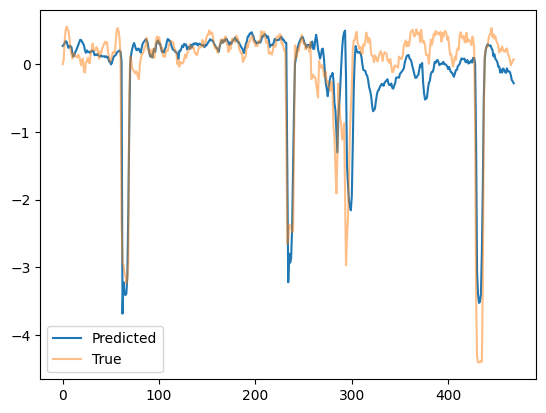

In [211]:
plt.plot(p_rnn[pod_feature], label="Predicted")
plt.plot(y_rnn[pod_feature], label="True", alpha=0.5)
plt.legend();